<a href="https://colab.research.google.com/github/atanilson/Comp702/blob/main/COMP702_Aplied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geospacial Data Processing Tools

* Google Earth Engine, Python Earth Engine Application
* GeoPanda Geospacial Analysis
* Rasterio
* Foliom

In [1]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [2]:
# Standard imports
import os
from tqdm.auto import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospacial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Model
import torch
from torchvision import datasets, models, transforms

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Authenticating in Google Earth Engine

In [4]:
ee.Authenticate()
ee.Initialize(project="atanilson-sgac")

# Downloading boundaries of the country of interest

Using geoBoundaries API

https://www.geoboundaries.org/api.html#api

END Point - https://www.geoboundaries.org/api/current/[RELEASE-TYPE]/[3-LETTER-ISO-CODE]/[BOUNDARY-TYPE]/

In [ ]:
# Area of interest and admin level
AOI = 'DEU'
ADM = "ADM3"

# Query geoBoundaries
url = f"https://www.geoboundaries.org/api/current/gbOpen/{AOI}/{ADM}"

r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Save the results as a GeoJSON
filename = "geoboundary.geojson"
geoboundary = requests.get(download_path).json()
with open(filename, "w") as file:
    geojson.dump(geoboundary, file)

In [7]:
# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (428, 6)


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
102,"Ansbach, Kreisfreie Stadt",,24449704B43646490285633,DEU,ADM3,"POLYGON ((10.58451 49.34231, 10.5824 49.34261,..."
127,"Kaufbeuren, Kreisfreie Stadt",,24449704B86570860401283,DEU,ADM3,"POLYGON ((10.63986 47.90656, 10.64045 47.90726..."
72,Kelheim,,24449704B11388891146558,DEU,ADM3,"POLYGON ((11.71955 48.78366, 11.71995 48.78225..."


Usning an example district, e.g. Kreis Borken

<Axes: >

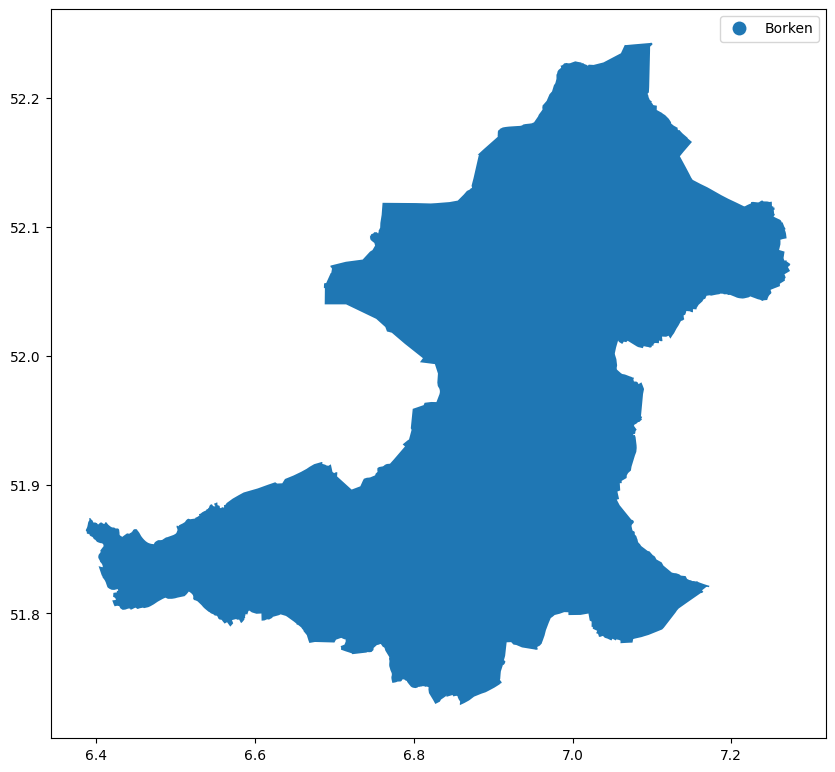

In [8]:
shape_name = "Borken"
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot("shapeName", legend=True, ax=ax)

# Google Earth Engine

In [9]:
def generate_image(
        region,
        product="COPERNICUS/S2",
        min_date="2018-01-01",
        max_date="2020-01-01",
        range_min=0,
        range_max=2000,
        cloud_pct=10):

    image = ee.ImageCollection(product)\
            .filterBounds(region)\
            .filterDate(str(min_date), str(max_date))\
            .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
            .median()

    # Get RGB image
    image = image.visualize(bands=["B4","B3","B1"], min=range_min, max=range_max)

    return image.clip(region)

In [10]:
## Generating and VIsualizing

In [13]:
# Getting the shape
region = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection

# Generate RGB image using GEE
image = generate_image(
    region,
    product="COPERNICUS/S2", # Sentinel-2A
    min_date = "2021-01-01", # Get all images within
    max_date="2021-12-31", # The year 2021
    cloud_pct=10, # Filter our image with cloud cover >= 10%
)

#Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, "Sentinel2")
Map.addLayerControl()
Map

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


# Exporting Image to google drive

In [14]:
def export_image(image, filename, region, folder):
    task = ee.batch.Export.image.toDrive(
        image=image,
        driveFolder = folder,
        scale=10,
        region=region.geometry(),
        description=filename,
        fileFormat="GeoTIFF",
        crs="EPSG:4326",
        maxPixels=900000000
    )
    task.start()
    return task

In [15]:
folder = "Colab Notebooks"
task = export_image(image, shape_name, region, folder)

In [17]:
task.status()

{'state': 'COMPLETED',
 'description': 'Borken',
 'priority': 100,
 'creation_timestamp_ms': 1751616363871,
 'update_timestamp_ms': 1751616837469,
 'start_timestamp_ms': 1751616372369,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1iq3-2fe-1Hcd_ExkPw6VpGJMZXlkKOHS'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 2090.25244140625,
 'id': 'GDNWTFX6XSCN2VYJPG4OFLN5',
 'name': 'projects/atanilson-sgac/operations/GDNWTFX6XSCN2VYJPG4OFLN5'}

# Cizualizing the downloaded imageMM

In [18]:
cwd = "./drive/My Drive/Colab Notebooks/"
tif_file = os.path.join(cwd, "{}.tif".format(shape_name))

#https://drive.google.com/file/d/14lbn8Y5Mh894Alie-7NwxvyQbHAMZtQK/view?usp=drive_link
# Downoading from google drive
if not os.path.isfile(tif_file):
    tif_file = "{}.tif".format(shape_name)
    !gdown "14lbn8Y5Mh894Alie-7NwxvyQbHAMZtQK"

<Axes: >

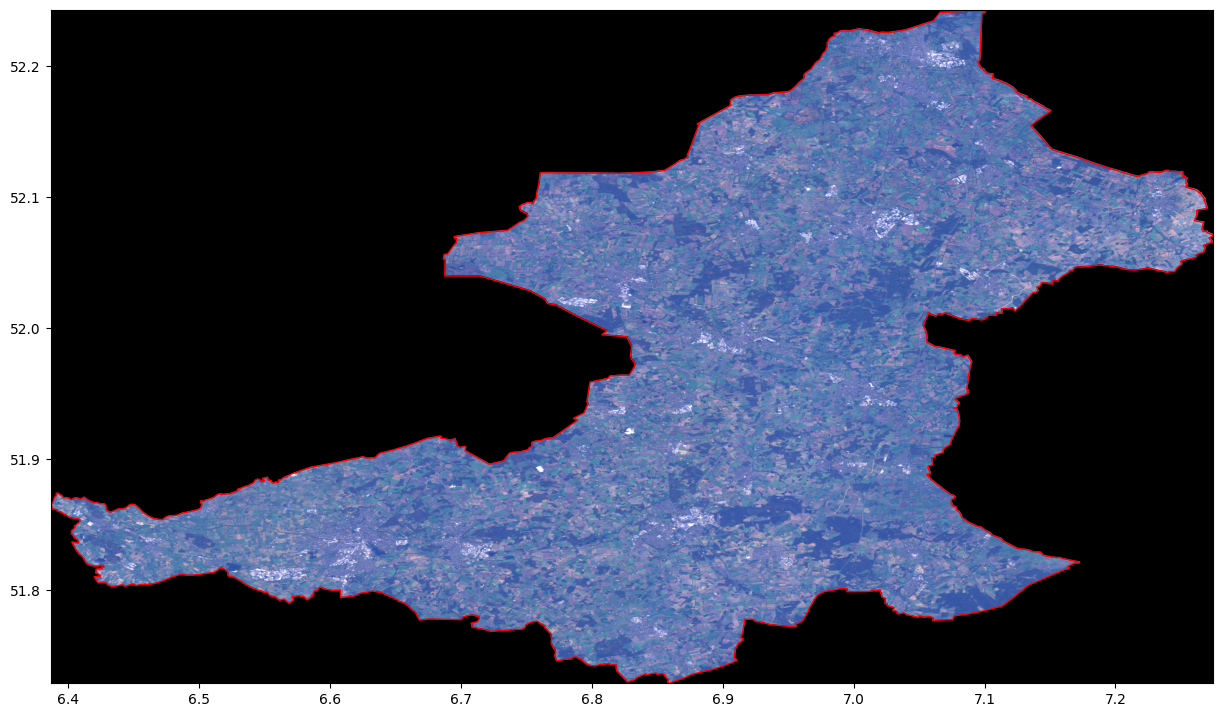

In [26]:
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and boundaries
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor="red", ax=ax)
show(image, ax=ax)

# Generating 64x64 Tiels

In [ ]:
## Function

In [27]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Genarates 64X64 polygon tiles.

    Args:
        image_file (str): Image file path (.tif)
        output_file
    """

    # Open the raser image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will conatin our 64Z64 px polygon tiles
    # Later convert this dict into GeoPandas DataFrame
    geo_dict = {"id":[],"geometry":[]}
    index = 0

    # Do a sliding windows across the raste image
    with tqdm(total=width*height) as pbar:
        for w in range(0, width, size):
            for h in range(0, height, size):
                # Create a Window of your disired size
                window = rio.windows.Window(h, w, size, size)

                # Get the georeferenced windowss bounds
                bbox = rio.windows.bounds(window, raster.transform)

                # Create a shapely geometry from the bounding box
                bbox = box(*bbox)

                # Create a unique id for each geometry
                uid = "{}-{}".format(area_str.lower().replace("","_"), index)

                # Update dictionary
                geo_dict["id"].append(uid)
                geo_dict["geometry"].append(bbox)

                index += 1
                pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))

    # Set CRS to EPSG: 4326
    results.crs = {"init":"epsg:4326"}

    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results


In [21]:
## Generating

In [28]:
output_file = os.path.join(cwd, "{}.geojson".format(shape_name))
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)

print("Data dimensions: {}".format(tiles.shape))
tiles.head(3)

  0%|          | 0/56585900 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (13950, 2)


,id,geometry
0,_b_o_r_k_e_n_-0,"POLYGON ((6.39241 52.23739, 6.39241 52.24314, ..."
1,_b_o_r_k_e_n_-1,"POLYGON ((6.39816 52.23739, 6.39816 52.24314, ..."
2,_b_o_r_k_e_n_-2,"POLYGON ((6.40391 52.23739, 6.40391 52.24314, ..."


# Visualizing 64x64 px Tiles and Images

<Axes: >

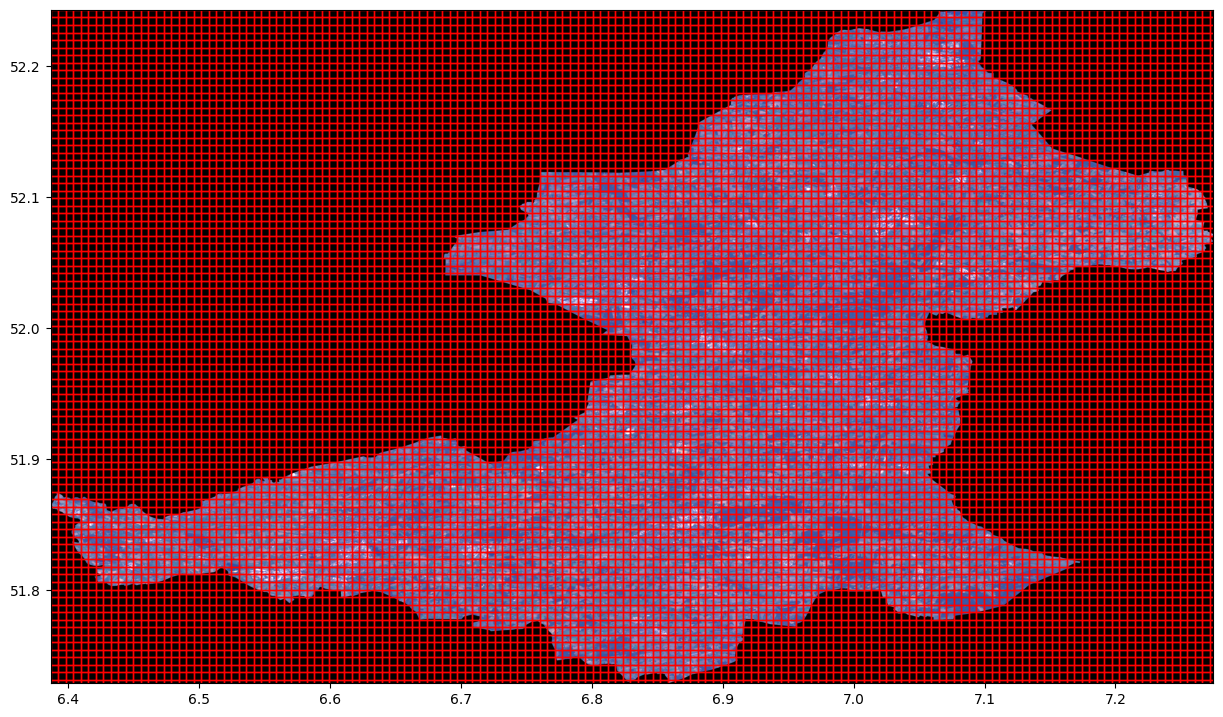

In [29]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize = (15,15))
tiles.plot(facecolor="none", edgecolor = "red", ax=ax)
show(image, ax=ax)

Deleating tiles outslide the region

/tmp/ipython-input-31-680641527.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, predicate="within")


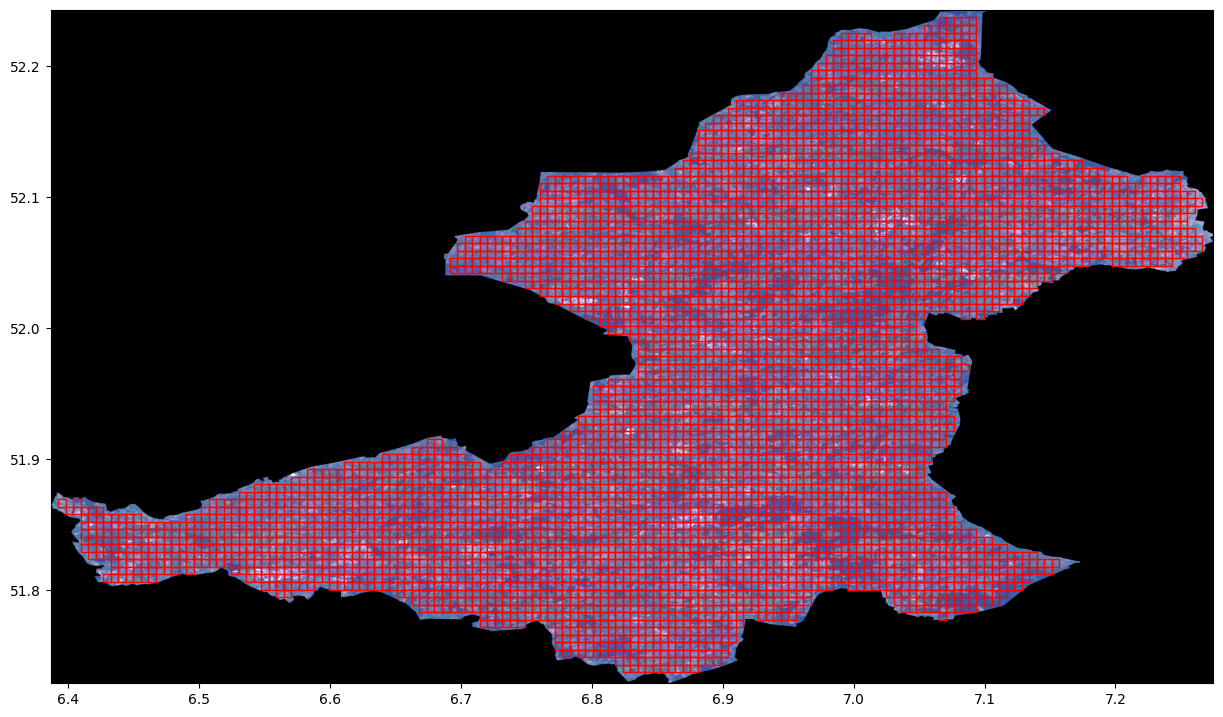

<Axes: >

In [31]:
image = rio.open(tif_file)

tiles = gpd.sjoin(tiles, boundary, predicate="within")

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor="red", ax=ax)
show(image, ax=ax)

# Vizualizing a single cropped image

In [32]:
def show_crop(image, shape, title=""):
    """
    Crop image base on the polyfon shape
    Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
    """

    with rio.open(image) as src:
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) boarder
        _, x_nonzero, y_nonzero = np.nonzero(out_image)

        out_image = out_image[
            :,
            np.min(x_nonzero):np.max(x_nonzero),
            np.min(y_nonzero):np.max(y_nonzero)
        ]
        # Visualize image
        show(out_image, title=title)

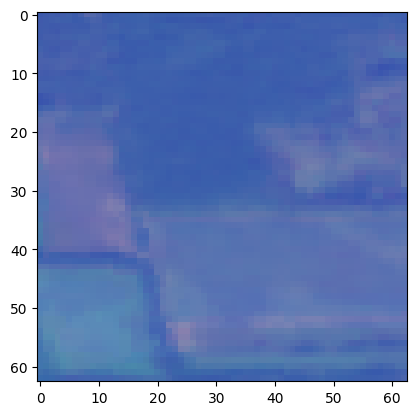

In [34]:
show_crop(tif_file, [tiles.iloc[4]["geometry"]])

# Genating the landcover map

In [35]:
# LULC Classes
classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
]

# Loading the model

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#model_file = cwd+"/models/model.pth"
model_file = "model_1.pth"

#if not os.path.isfile(model_file):
#    model_file = "model.pth"
#    !gdown "--ID--"


In [38]:
from torch import nn

In [39]:
class CNN_Model1(nn.Module):
  """
  Model ...
  """
  def __init__(self, input_shape: int,hidden_units: int, output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )
    self.pooling = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*13*13,
            out_features=output_shape
        )
    #self.pooling = nn.Sequential(nn.Flatten(), nn.LazyLinear(out_features=output_shape)) out maticlay get the in_fitures
    )

  def forward(self,x):
    #print(x.shape)
    #x=self.conv_block_1(x)
    #print(x.shape)
    #x=self.conv_block_2(x)
    #print(x.shape)
    #x=self.pooling(x)
    #print(x.shape)
    #return x
    return self.pooling(self.conv_block_2(self.conv_block_1(x)))


In [44]:
model_1 = CNN_Model1(input_shape=3,
                    hidden_units=10,
                    output_shape=len(classes)).to(device)

In [45]:
model_1.load_state_dict(torch.load(model_file, map_location=device))
model_1.eval()

print("Model file {} sucessfully loaded.".format(model_file))

Model file model_1.pth sucessfully loaded.


In [46]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prediction and LC Generation

In [47]:
def predict_crop(image, shape, classes, model, show=False):
    """
    Generate prediciton
    """
    with rio.open(image) as src:
        # Crop source image using polyhon shape
        ## https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

        out_image, out_transform = rio.mask.mask(src, shape, crop=True)

        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
            :,
            np.min(x_nonzero):np.max(x_nonzero),
            np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transfor, of the cropped image
        out_meta = src.meta
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "tranform": out_transform
        })

        # Save the cropped image as a temporatry TIFF file.
        temp_tif = "temp.tif"
        with rio.open(temp_tif, "w", **out_meta) as dest:
            dest.write(out_image)

        # Open the cropped image and genrated prediction
        # Using the model
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
            out_image.show(title=label)

        return label

    return None

Iterating iver the 64x64 pile and genarating model predictions for the corresponding cropped image. Note htat we are overwritting each temporary TIFF file ro save storage space

In [ ]:
#
labels = [] # Stor prediction
for index in tqdm(range(len(tiles)), total=len(tiles)):
    label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model_1)
    labels.append(label)
tiles['pred'] = labels

#Save prediction
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)